In [1]:
import cv2 as cv
import sys
import pywt

import numpy as np
from matplotlib import pyplot as plt

import os

In [2]:
np.seterr('raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Color Histogram

In [3]:
def get_color_histogram(img):
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    n_channels = hsv.shape[2]
    channels = list(range(n_channels))
    sizes = [8,]*n_channels
    ranges = [0, 256]*n_channels
    hist = cv.calcHist(hsv, channels, None, sizes, ranges)
    return hist

# WBCH

In [4]:
def get_texture_histogram(img):
    b,g,r = cv.split(img)
    approx = []
    horiz = []
    vert = []
    for x in [b,g,r]:
        cA, (cH, cV, _) = pywt.dwt2(x, 'haar')
        approx.append(cA)
        horiz.append(cH)
        vert.append(cV)
    img_approx = cv.merge(approx)
    img_horiz = cv.merge(horiz)
    img_vert = cv.merge(vert)
    # Step 5: assign weights to approx, horiz, and vert
    new_img = cv.addWeighted(img_approx, 0.75, img_horiz, 0.25, 0.0)
    new_img = cv.addWeighted(new_img, 0.8, img_vert, 0.2, 0.0)
    return get_color_histogram(new_img.astype('float32'))

# Distance Metric

## Histogram intersection

In [5]:
def get_distance(histA,histB):
    histA = histA.flatten()
    histA = histA/(sum(histA))
    histB = histB.flatten()
    histB = histB/(sum(histB))
    denominator = min(np.sum(histA),np.sum(histB))
    numerator = 0
    for i in range(0,8*8*8):
        minimum = histA[i] if histA[i] < histB[i] else histB[i]
        numerator = numerator+minimum
    return 1-numerator/denominator

## Chi - squared distance

In [6]:
def get_chi_distance(histA,histB):
    histA = histA.flatten()
    histA = histA/(sum(histA))
    histB = histB.flatten()
    histB = histB/(sum(histB))
    dist = 0.0
    for i in range(0,8*8*8):
        denom = histA[i]+histB[i]
        if denom != 0:
            dist = dist + np.square((histA[i]-histB[i]))/(histA[i]+histB[i])
    return dist*0.5

# Image matching

In [7]:
def get_best_match(queryfilepath,distance_used):
    Q = cv.imread(queryfilepath)
    directory = 'faces_6class'
    min_dist = float('inf')
    Q_best_match = np.zeros(Q.shape)
    Q_best_match_movement = ''
    
    for folder in os.listdir(directory):
        folderpath = os.path.join(directory,folder)
        if os.path.isdir(folderpath):
            for file in os.listdir(folderpath):
                filepath = os.path.join(folderpath,file)
                if os.path.isfile(filepath):
                    D = cv.imread(filepath)
                    Q_hist_color = get_color_histogram(Q)
                    D_hist_color = get_color_histogram(D)
                    Q_hist_texture = get_texture_histogram(Q)
                    D_hist_texture = get_texture_histogram(D)
                    if distance_used == '1':
                        dist_color = get_distance(Q_hist_color,D_hist_color)
                        dist_texture = get_distance(Q_hist_texture,D_hist_texture)
                    else:
                        dist_color = get_chi_distance(Q_hist_color,D_hist_color)
                        dist_texture = get_chi_distance(Q_hist_texture,D_hist_texture)             
                    dist = (dist_color+dist_texture)/2
                    if dist < min_dist and filepath != queryfilepath:
                        min_dist = dist
                        Q_best_match = D
                        Q_best_match_movement = folder
    return Q_best_match, Q_best_match_movement

Insert filepath to the query image. 
faces_6class/face_NorthernRenaiss/the-virgin-and-child.jpg
Choose distance. Insert 1 for intersection and 2 for chi squared. 
2


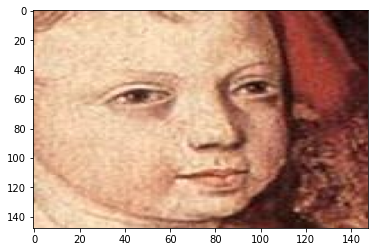

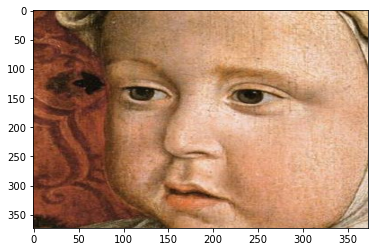

Query movement is:  face_NorthernRenaiss
Match movement is:  face_NorthernRenaiss


In [10]:
queryfilepath = input("Insert filepath to the query image. \n")
Q = cv.imread(queryfilepath)
while(Q is None):
    queryfilepath = input('Not a valid file. Insert again. \n')
    Q = cv.imread(queryfilepath)
    
distance_used = input('Choose distance. Insert 1 for intersection and 2 for chi squared. \n')
while(distance_used != '1' and distance_used != '2'):
    distance_used = input('Not a valid choice. Insert 1 for intersection and 2 for chi squared. \n')

Q_best_match, Q_best_match_movement = get_best_match(queryfilepath,distance_used)

plt.imshow(cv.cvtColor(Q, cv.COLOR_BGR2RGB),aspect="auto")
plt.show()

plt.imshow(cv.cvtColor(Q_best_match, cv.COLOR_BGR2RGB),aspect="auto")
plt.show()

print("Query movement is: ", queryfilepath.split('/')[1])
print("Match movement is: ",Q_best_match_movement)